In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
if torch.backends.mps.is_available():
    print("MPS is available.")
else:
    print("MPS is not available.")
print(torch.backends.mps.is_built())

MPS is available.
True


# 1. Data Preparation

In [7]:
# Define transformations & Load the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2),)
    ])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [8]:
def show_images(images, labels, max_images=16):
    plt.figure(figsize=(10, 10))
    images = images[:max_images]  # Limit to max_images (16)
    labels = labels[:max_images]  # Limit to max_images (16)
    
    for i in range(len(images)):
        plt.subplot(4, 4, i+1)  # Create a 4x4 grid
        plt.imshow(images[i].squeeze(), cmap='gray')  # Display the image
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

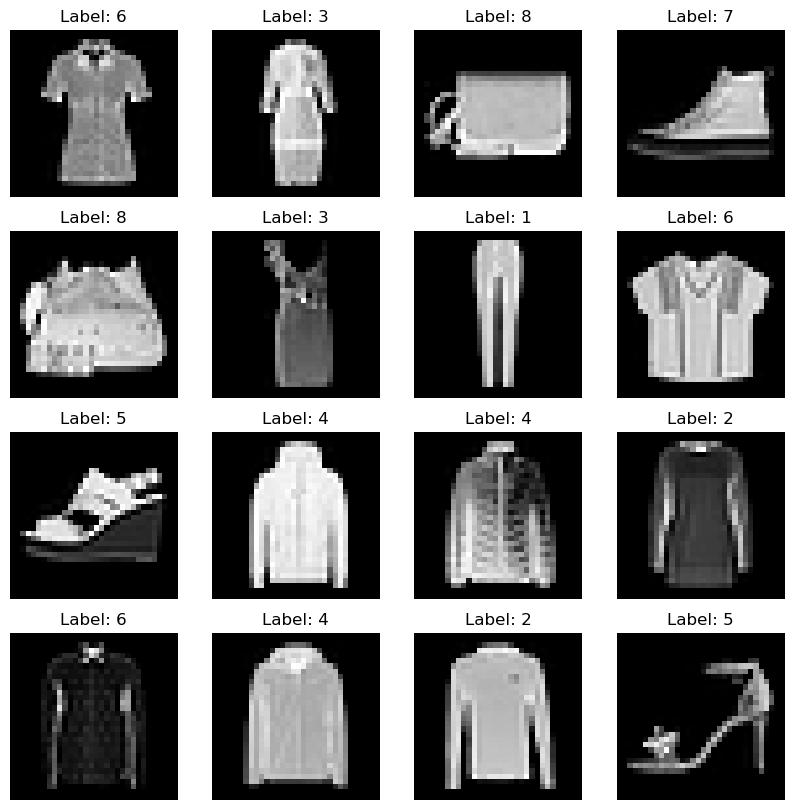

In [9]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Display the images
show_images(images, labels)

# 2. VAE

In [10]:
# Sampling layer using reparameterization trick
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_log_var).to(z_mean.device)  # Generate random noise
        z = z_mean + torch.exp(0.5 * z_log_var) * epsilon  # Reparameterization trick
        return z

# Encoder network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # (None, 16, 16, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # (None, 8, 8, 64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # (None, 4, 4, 128)
        self.flatten = nn.Flatten()  # Flatten to (None, 2048)

        # Dense layers for latent mean and log variance
        self.fc_z_mean = nn.Linear(128 * 4 * 4, 2)  # (None, 2)
        self.fc_z_log_var = nn.Linear(128 * 4 * 4, 2)  # (None, 2)
        self.sampling = Sampling()

    def forward(self, x):
        # Pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)

        # Compute mean and log variance
        z_mean = self.fc_z_mean(x)
        z_log_var = self.fc_z_log_var(x)

        # Sampling from latent space
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

# Decoder network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Dense layer
        self.fc = nn.Linear(2, 128 * 4 * 4)  # Map from latent space to flattened representation (2048)
        
        # Transposed convolutional layers for upsampling
        self.conv_transpose1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # (None, 8, 8, 128)
        self.conv_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # (None, 16, 16, 64)
        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (None, 32, 32, 32)
        self.conv_output = nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Final output layer (None, 32, 32, 1)

    def forward(self, z):
        # Pass through fully connected layer and reshape
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (None, 128, 4, 4)

        # Pass through transposed convolutional layers
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = F.relu(self.conv_transpose3(x))
        x = torch.sigmoid(self.conv_output(x))  # Sigmoid to ensure values are between 0 and 1
        return x

In [11]:
# Define VAE model combining encoder and decoder
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        # Loss trackers
        self.total_loss_tracker = []
        self.reconstruction_loss_tracker = []
        self.kl_loss_tracker = []
        
    def forward(self, x):
        """Forward pass of VAE"""
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def loss_function(self, reconstruction, data, z_mean, z_log_var, beta=1.0):
        """Loss function with reconstruction loss and KL divergence"""
        reconstruction_loss = F.binary_cross_entropy(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        total_loss = reconstruction_loss + beta * kl_loss # Loss function: reconstruction + KL divergence
        return total_loss, reconstruction_loss, kl_loss
    
    def train_step(self, data, optimizer, beta=1.0):
        """Custom training step"""
        self.train()  # Set to training mode
        optimizer.zero_grad()
        
        # Forward pass
        z_mean, z_log_var, reconstruction = self(data)
        
        # Compute losses
        total_loss, reconstruction_loss, kl_loss = self.loss_function(reconstruction, data, z_mean, z_log_var, beta)
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Track losses
        self.total_loss_tracker.append(total_loss.item())
        self.reconstruction_loss_tracker.append(reconstruction_loss.item())
        self.kl_loss_tracker.append(kl_loss.item())

        return {
            "total_loss": total_loss.item(),
            "reconstruction_loss": reconstruction_loss.item(),
            "kl_loss": kl_loss.item(),
        }

In [12]:
# Instantiate the model
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder, decoder)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
vae = vae.to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [15]:
# Function to save the model
def save_checkpoint(model, optimizer, epoch, filepath='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    # encoder와 decoder를 따로 저장
    torch.save(encoder.state_dict(), './models/encoder.pth')
    torch.save(decoder.state_dict(), './models/decoder.pth')
    # model 전체 저장
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

# Function to load the model
def load_checkpoint(filepath, model, optimizer):
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded from {filepath}")
        return checkpoint['epoch']
    else:
        print(f"No checkpoint found at {filepath}")
        return 0  # Start training from epoch 0 if no checkpoint is found

In [17]:
# 학습 루프
num_epochs = 10
start_epoch = 0
save_interval = 1  # 몇 에포크마다 저장할지 설정

best_loss = float('inf')  # 최초에는 무한대로 설정

for epoch in range(start_epoch, num_epochs):
    vae.train()  # 모델을 학습 모드로 설정
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        train_results = vae.train_step(data, optimizer)

        # 배치 손실을 누적하여 에폭 손실 계산
        epoch_loss += train_results['total_loss']

        # # 학습 상태를 콘솔에 출력 (200 배치마다 출력)
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], "
                  f"Total Loss: {train_results['total_loss']:.4f}, "
                  f"Reconstruction Loss: {train_results['reconstruction_loss']:.4f}, "
                  f"KL Loss: {train_results['kl_loss']:.4f}")

    # 에폭이 끝날 때 총 에폭 손실을 출력
    print(f"Epoch [{epoch+1}/{num_epochs}] Finished. Total Epoch Loss: {epoch_loss:.4f}")

    # 현재 에폭 손실이 지금까지의 최소 손실보다 작으면 모델 저장
    if epoch_loss < best_loss:
        best_loss = epoch_loss  # 최소 손실 업데이트
        save_checkpoint(vae, optimizer, epoch + 1, filepath='./models/vae.pth')
        print(f"New best model saved with loss {best_loss:.4f}")

Epoch [1/10], Step [0/938], Total Loss: 17779.9844, Reconstruction Loss: 17402.3906, KL Loss: 377.5947
Epoch [1/10], Step [200/938], Total Loss: 17047.3613, Reconstruction Loss: 16664.6055, KL Loss: 382.7555
Epoch [1/10], Step [400/938], Total Loss: 17431.1699, Reconstruction Loss: 17055.2910, KL Loss: 375.8792
Epoch [1/10], Step [600/938], Total Loss: 15362.4883, Reconstruction Loss: 14978.9639, KL Loss: 383.5244
Epoch [1/10], Step [800/938], Total Loss: 16889.0137, Reconstruction Loss: 16507.4297, KL Loss: 381.5830
Epoch [1/10] Finished. Total Epoch Loss: 15935821.0439
Checkpoint saved at ./models/vae.pth
New best model saved with loss 15935821.0439
Epoch [2/10], Step [0/938], Total Loss: 15652.1475, Reconstruction Loss: 15273.1445, KL Loss: 379.0033
Epoch [2/10], Step [200/938], Total Loss: 16841.6270, Reconstruction Loss: 16457.6621, KL Loss: 383.9658
Epoch [2/10], Step [400/938], Total Loss: 16677.8906, Reconstruction Loss: 16286.3301, KL Loss: 391.5603
Epoch [2/10], Step [600/938

# 3. Test

In [18]:
# VAE 모델에서 예측을 수행하는 함수
def predict(vae, data):
    vae.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():  # 그라디언트 계산 방지
        z_mean, z_log_var, reconstructions = vae(data)
    return z_mean, z_log_var, reconstructions

def reparameterize(z_mean, z_var):
    std = torch.exp(0.5 * z_var)  # 분산을 표준편차로 변환
    eps = torch.randn_like(std)   # 표준 정규분포에서 샘플링
    z = z_mean + eps * std        # Reparameterization trick
    return z

def encoder_predict(encoder, data):
    encoder.eval() 
    with torch.no_grad(): 
        z_mean, z_var = encoder(data)  # 인코더를 통해 z_mean, z_var 계산
        z = reparameterize(z_mean, z_var)  # Reparameterization trick을 통해 z 샘플링
    return z_mean, z_var, z

def decoder_predict(decoder, z_sample, device):
    decoder.eval()  
    z_sample = torch.tensor(z_sample, dtype=torch.float32).to(device)  # numpy 배열을 텐서로 변환하고 GPU로 이동
    
    with torch.no_grad():  # 그라디언트 계산 방지
        reconstructions = decoder(z_sample)  # 디코더를 통해 재구성된 이미지 생성
    
    return reconstructions


# 예측 후 이미지 시각화를 위한 함수
def display_images(images, title):
    images = images.cpu().numpy()  # 텐서를 넘파이로 변환
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i, image in enumerate(images):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

실제 의류 아이템


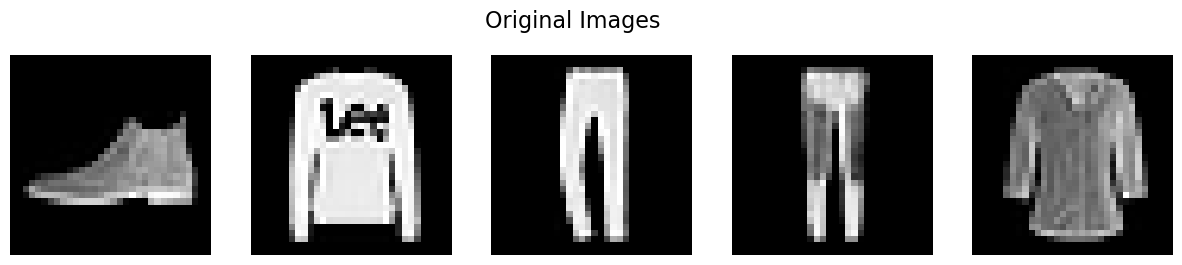

재구성 이미지


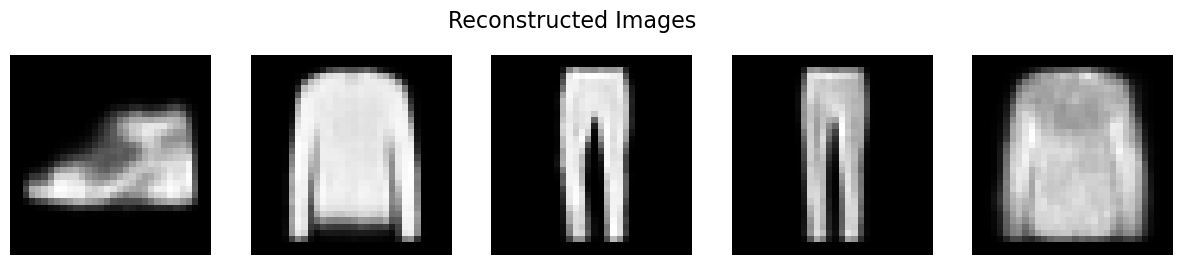

In [19]:
example_images, _ = next(iter(test_loader))  # 예를 들어 test_loader에서 배치 가져오기
example_images = example_images.to(device)  # 데이터를 GPU로 이동

z_mean, z_log_var, reconstructions = predict(vae, example_images)

# 실제 의류 아이템 출력
print("실제 의류 아이템")
display_images(example_images[:5], title="Original Images")  # 예시로 처음 5개 이미지를 출력

# 재구성된 이미지 출력
print("재구성 이미지")
display_images(reconstructions[:5], title="Reconstructed Images")

# 3.1 Encoder

In [20]:
def extract_z_values(vae, data_loader, device):
    vae.eval()  # 모델을 평가 모드로 전환
    all_z_mean = []
    all_z_log_var = []

    with torch.no_grad():  # 그라디언트 계산 방지
        for images, _ in data_loader:
            images = images.to(device)  # 데이터를 GPU로 이동
            z_mean, z_log_var, _ = predict(vae, images)  # z_mean과 z_log_var 추출
            all_z_mean.append(z_mean.cpu())  # z_mean을 CPU로 이동 후 저장
            all_z_log_var.append(z_log_var.cpu())  # z_log_var를 CPU로 이동 후 저장

    # 리스트를 하나의 텐서로 결합
    all_z_mean = torch.cat(all_z_mean, dim=0)
    all_z_log_var = torch.cat(all_z_log_var, dim=0)
    
    return all_z_mean, all_z_log_var

# 모든 테스트 데이터에서 z_mean, z_log_var를 추출
all_z_mean, all_z_log_var = extract_z_values(vae, test_loader, device)

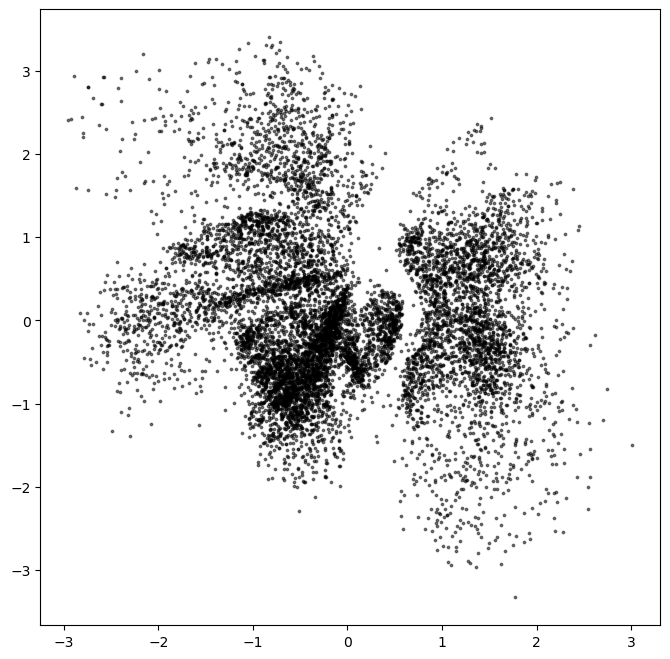

In [21]:
# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

# GPU에 있는 텐서를 detach() 후 CPU로 이동, numpy로 변환
z = all_z_mean.detach().cpu().numpy()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# 3.2 Decoder

In [22]:
# 잠재 공간에서 2D 포인트를 샘플링 (표준 정규분포에서 샘플링)
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))  # 2D 잠재 공간에서 샘플링

# 샘플링된 포인트를 디코딩
reconstructions = decoder_predict(decoder, z_sample, device)

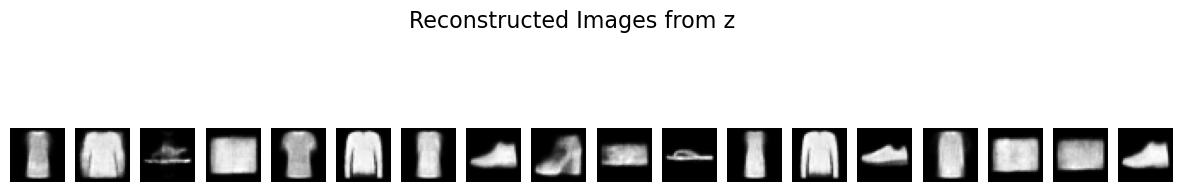

In [23]:
# 재구성된 이미지를 출력하기 위해 CPU로 이동
reconstructions = reconstructions.cpu()

# 재구성된 이미지 시각화
display_images(reconstructions, title="Reconstructed Images from z")

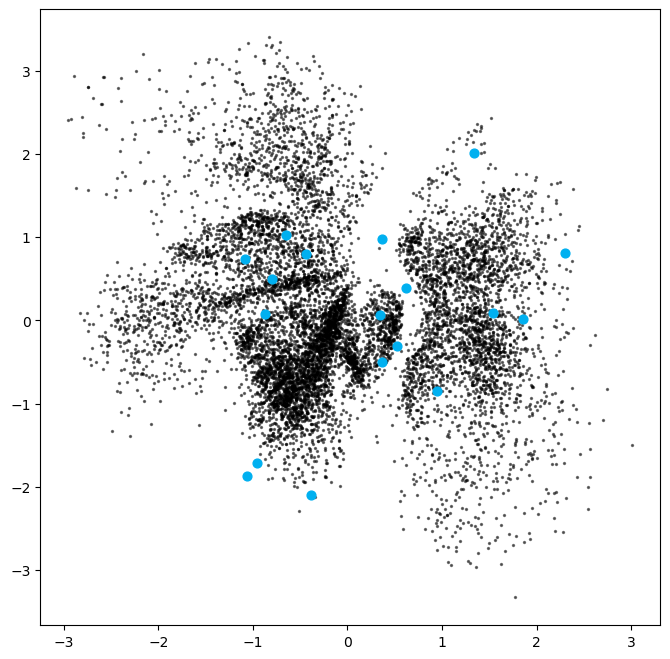

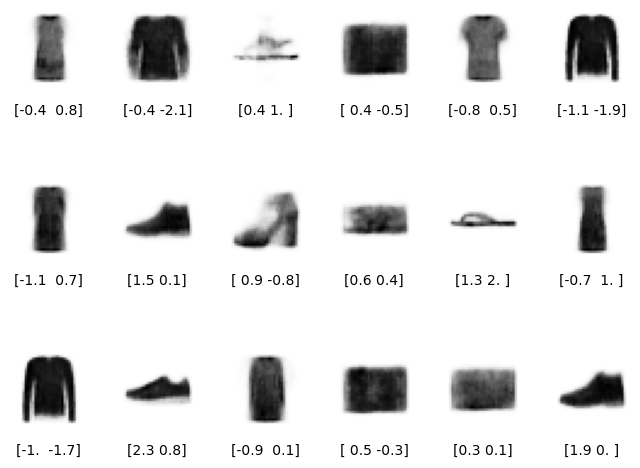

In [24]:
# 1. 잠재 공간에서 샘플링된 포인트와 원본 임베딩을 시각화
figsize = 8
plt.figure(figsize=(figsize, figsize))

# 원본 임베딩 시각화 
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# 새롭게 샘플링된 포인트 시각화 (z_sample은 이미 넘파이 배열임)
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 2. 디코딩된 이미지 그리드 시각화
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 재구성된 이미지를 순차적으로 그리드에 추가
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    
    # z_sample 포인트 텍스트 추가
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    
    # 재구성된 이미지 시각화 (reconstructions도 GPU에 있을 수 있으므로 CPU로 변환 필요)
    img = reconstructions[i].detach().cpu().numpy().squeeze()  # 이미지 변환
    ax.imshow(img, cmap="Greys")

plt.show()